In [1]:
import xarray as xr
import pandas as pd
import os
import numpy as np

## Netcdf cleaning example

This is an example of cleaning data accessed in netcdf format and preparing it for analysis. 

The dataset we will use contains InSAR-derived ice velocity for 10 years over the Amundsen sea embayment in Antarctica. The data is downloaded from: https://nsidc.org/data/NSIDC-0545/versions/1

downloaded data is `.hdr` and `.dat` files for each year, and a `.nc` for all of the years together. 

The `.nc` object is a dataset with dimensions x,y and data vars for each year. So for each year there are `vx`,`vy`,`err` vars. We'd like to re-organize this so that there are 3 variables (`vx`, `vy` and `err`) that exist along a time dimension.

In [2]:
!pwd

/Users/emarshall/Desktop/siparcs/netcdf_example/netcdf_example


In [3]:
ds = xr.open_dataset('ASE_ice_velocity.nc')

Take a look at the dataset:

In [4]:
ds.dims

Frozen({'ny': 800, 'nx': 500})

Check the projection:

In [5]:
ds.attrs['Projection']

'         Polar Stereographic South'

In [6]:
ds

<xarray.Dataset>
Dimensions:  (ny: 800, nx: 500)
Coordinates:
  * nx       (nx) int64 500 501 502 503 504 505 506 ... 994 995 996 997 998 999
  * ny       (ny) int64 200 201 202 203 204 205 206 ... 994 995 996 997 998 999
Data variables: (12/32)
    vx1996   (ny, nx) float32 ...
    vy1996   (ny, nx) float32 ...
    err1996  (ny, nx) float32 ...
    vx2000   (ny, nx) float32 ...
    vy2000   (ny, nx) float32 ...
    err2000  (ny, nx) float32 ...
    ...       ...
    err2011  (ny, nx) float32 ...
    vx2012   (ny, nx) float32 ...
    vy2012   (ny, nx) float32 ...
    err2012  (ny, nx) float32 ...
    xaxis    (nx) float32 ...
    yaxis    (ny) float32 ...
Attributes: (12/21)
    Title:                ASE Time Series - Ice Velocity
    Version:              1.0.0 (18Oct2013)
    nx:                   1707
    ny:                   2268
    Projection:                    Polar Stereographic South
    Ellipsoid:                      WGS-84
    ...                   ...
    Reference:                Mouginot J., B. Scheuchl and E. Rignot (2012), ...
    Notes_2:                    Please also include the following data set re...
    Data_citation:        NSIDC Citation Rignot, E., J. Mouginot, and B. Sche...
    More_information:     http://nsidc.org/data/nsidc-0545.html
    Notes_3:                       Data were processed at the Department of E...
    Description:          Created a spatial subset of original dataset. Selec...

Currently the dimensions on the object are `ny` and `nx` but the object has no coordinates. If we look in the `data_vars` we can see there are two variables named `xaxis` and `yaxis`. Let's confirm that they match the dimensions `nx` and `ny` in length and then assign them as coordinates:

In [7]:
ds.dims['ny']

800

In [8]:
len(ds.yaxis.data)


800

We'll assign the `xaxis` and `yaxis` vars to be coordinates, and drop them from the `data_vars`:

In [9]:
ds = (ds.assign_coords(coords = {'x':ds.xaxis, 'y':ds.yaxis}).
      drop_vars(['xaxis','yaxis'])).swap_dims({'ny':'y', 'nx':'x'})
ds

<xarray.Dataset>
Dimensions:  (y: 800, x: 500)
Coordinates:
    nx       (x) int64 500 501 502 503 504 505 506 ... 994 995 996 997 998 999
    ny       (y) int64 200 201 202 203 204 205 206 ... 994 995 996 997 998 999
  * x        (x) float32 -1.581e+06 -1.581e+06 ... -1.357e+06 -1.357e+06
  * y        (y) float32 -7.032e+05 -7.028e+05 ... -3.442e+05 -3.437e+05
Data variables: (12/30)
    vx1996   (y, x) float32 ...
    vy1996   (y, x) float32 ...
    err1996  (y, x) float32 ...
    vx2000   (y, x) float32 ...
    vy2000   (y, x) float32 ...
    err2000  (y, x) float32 ...
    ...       ...
    vx2011   (y, x) float32 ...
    vy2011   (y, x) float32 ...
    err2011  (y, x) float32 ...
    vx2012   (y, x) float32 ...
    vy2012   (y, x) float32 ...
    err2012  (y, x) float32 ...
Attributes: (12/21)
    Title:                ASE Time Series - Ice Velocity
    Version:              1.0.0 (18Oct2013)
    nx:                   1707
    ny:                   2268
    Projection:                    Polar Stereographic South
    Ellipsoid:                      WGS-84
    ...                   ...
    Reference:                Mouginot J., B. Scheuchl and E. Rignot (2012), ...
    Notes_2:                    Please also include the following data set re...
    Data_citation:        NSIDC Citation Rignot, E., J. Mouginot, and B. Sche...
    More_information:     http://nsidc.org/data/nsidc-0545.html
    Notes_3:                       Data were processed at the Department of E...
    Description:          Created a spatial subset of original dataset. Selec...

Now we have x and y coordinates and 30 data variables. However, the `data_vars` are really only 3 unique variables that exist along a time dimension (with a length of 10). 
We want to add a time dimension to the dataset and concatenate the data variables in each of the three groups together.

Start by making a few objects that we'll use while we're re-organizing. These are: a list of all the variables in the dataset (`var_ls`), a list of the years covered by the dataset that are currently stored in variable names (`yr_ls`) and then finally lists for each variable (`vx_ls`,`vy_ls` and `err_ls`). These are all of the variables in the original dataset that correspond with that main variable group (vx, vy or err).

In [11]:
#var_ls = list(am_vel.data_vars.keys())
var_ls = list(ds)

yr_ls = list(set([var[-4:] for var in var_ls]))

yr_ls = sorted([pd.to_datetime(year).year for year in yr_ls])
yr_ls

[1996, 2000, 2002, 2006, 2007, 2008, 2009, 2010, 2011, 2012]

In [12]:
#variables_ls = list(am_vel)

vx_ls = [var for var in var_ls if 'vx' in var]
vy_ls = [var for var in var_ls if 'vy' in var]
err_ls = [var for var in var_ls if 'err' in var]

Now we are going to group the `dataset.data_vars` into `vx`, `vy` and `err` and prepare to concatenate them along the time dimension. 
In the cell below, for each variable, we are making a list of the `xr.DataArray` in the original `xr.Dataset` that corresponds to that variable. But within that command we are also creating a new dimension (`time`) that we will use to concatenate the variables. There is a great explanation of this kind of step [here](https://towardsdatascience.com/pythonic-way-to-perform-statistics-across-multiple-variables-with-xarray-d0221c78e34a). At the end of this step, for `vx`, `vy` and `err` we will have a list of `xr.DataArrays` that all have a time dimension on the 0-axis. 

In [13]:
da_vx_ls = [ds[var].expand_dims('time', axis=0).
            assign_coords(time=[var]).
            rename('vx') for var in vx_ls]

da_vy_ls = [ds[var].expand_dims('time', axis=0).
            assign_coords(time=[var]).
            rename('vy') for var in vy_ls]
                          
da_err_ls = [ds[var].expand_dims('time',axis=0).
            assign_coords(time=[var]).
            rename('err') for var in err_ls]

Once we have these lists, we will concatenate them together to a single `xr.DataArray` with `x`,`y` and `time` dimensions. In the above step, when we create the time dimension we assign a stand-in for the time coordinate. In the cell below, we'll use the `yr_ls` object that we created that is a list whose elements are time-aware objects correspondign to the time coordinates (originally in the variable names). The final line in the cell below merges the three `xr.DataArray`s on the common `time` dimension that they now share, so we have a `xr.Dataset` with `x`,`y` and `time` dimensions and `vx`, `vy` and `err` variables.

In [14]:
vx_concat = xr.concat(da_vx_ls, dim='time')
vy_concat = xr.concat(da_vy_ls, dim = 'time')
err_concat = xr.concat(da_err_ls, dim='time')

vx_concat['time'] = yr_ls
vy_concat['time'] = yr_ls
err_concat['time'] = yr_ls

ds_merge = xr.merge([vx_concat, vy_concat, err_concat])

In [15]:
ds_merge

<xarray.Dataset>
Dimensions:  (x: 500, y: 800, time: 10)
Coordinates:
    nx       (x) int64 500 501 502 503 504 505 506 ... 994 995 996 997 998 999
    ny       (y) int64 200 201 202 203 204 205 206 ... 994 995 996 997 998 999
  * x        (x) float32 -1.581e+06 -1.581e+06 ... -1.357e+06 -1.357e+06
  * y        (y) float32 -7.032e+05 -7.028e+05 ... -3.442e+05 -3.437e+05
  * time     (time) int64 1996 2000 2002 2006 2007 2008 2009 2010 2011 2012
Data variables:
    vx       (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    vy       (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    err      (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    Content:  Ice velocity in x direction
    Units:      meter/year

We'll add a variable that is magnitude of velocity as well

In [16]:
ds_merge['speed'] = np.sqrt((ds_merge.vx**2) + (ds_merge.vy**2))

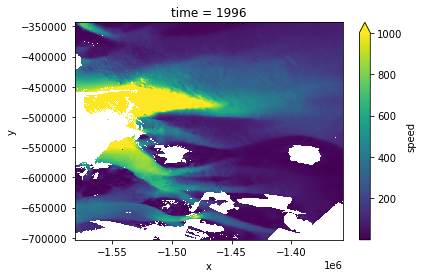

In [17]:
ds_merge.speed.isel(time=0).plot(vmax=1000)

and add the `attrs` of the original object to our new object, `ds_full`

In [18]:
ds_merge.attrs = ds.attrs

In [19]:
ds_merge

<xarray.Dataset>
Dimensions:  (x: 500, y: 800, time: 10)
Coordinates:
    nx       (x) int64 500 501 502 503 504 505 506 ... 994 995 996 997 998 999
    ny       (y) int64 200 201 202 203 204 205 206 ... 994 995 996 997 998 999
  * x        (x) float32 -1.581e+06 -1.581e+06 ... -1.357e+06 -1.357e+06
  * y        (y) float32 -7.032e+05 -7.028e+05 ... -3.442e+05 -3.437e+05
  * time     (time) int64 1996 2000 2002 2006 2007 2008 2009 2010 2011 2012
Data variables:
    vx       (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    vy       (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    err      (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    speed    (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
Attributes: (12/21)
    Title:                ASE Time Series - Ice Velocity
    Version:              1.0.0 (18Oct2013)
    nx:                   1707
    ny:                   2268
    Projection:                    Polar Stereographic South
    Ellipsoid:                      WGS-84
    ...                   ...
    Reference:                Mouginot J., B. Scheuchl and E. Rignot (2012), ...
    Notes_2:                    Please also include the following data set re...
    Data_citation:        NSIDC Citation Rignot, E., J. Mouginot, and B. Sche...
    More_information:     http://nsidc.org/data/nsidc-0545.html
    Notes_3:                       Data were processed at the Department of E...
    Description:          Created a spatial subset of original dataset. Selec...

Checking against original version to make sure it's the same

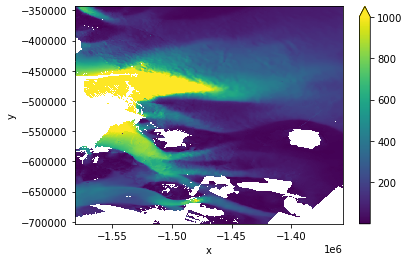

In [20]:
np.sqrt((ds.vx1996**2) + (ds.vy1996**2)).plot(vmax=1000)